# Multiple Subject Processing

In [47]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [48]:
import mne
from mne_bids import (BIDSPath,read_raw_bids)
from mne.io import RawArray
import sys
sys.path.insert(0,'.')
import os
import numpy as np
import gc

import ccs_eeg_utils
from visualization import show_single_psd, psd_compare, iclabel_visualize, plot_erp
from s00_add_reference import add_reference_channel
from s01_downsample_filter import down_sampling, band_filter, notch_filter, zapline_filter
from s02_drop_bad_channels import drop_bad_channels, reref
from s03_07_trial_rejection import trial_rejection_cust, trial_rejection_mne
from s04_ICA import get_ica, get_iclabel, iccomponent_removal, iccomponent_removal_author, iccomponent_removal_new
from s05_interpolation import interpolation
from s06_early_trial_removal import exclude_early_trials
from s07_epoching import epoching, epoching_cust
from s08_find_bad_channels import find_bad_channels
from s09_make_erps import get_evoked

In [49]:
CONDITIONS_DICT = {
    # Feedback-Locked Conditions
    'Low-Low Win':   ['Stimulus:S  6'], 
    'Low-Low Loss':  ['Stimulus:S  7'], 
    'Mid-Low Win':   ['Stimulus:S 16'], 
    'Mid-Low Loss':  ['Stimulus:S 17'], 
    'Mid-High Win':  ['Stimulus:S 26'], 
    'Mid-High Loss': ['Stimulus:S 27'],
    'High-High Win': ['Stimulus:S 36'], 
    'High-High Loss':['Stimulus:S 37'],
}

In [50]:
'''Zheng path'''
#bids_root = "C:\\Users\\Zheng\\Desktop\\fourth semester\\EEG\\reward_dataset\\reward_dataset\\reward_dataset"

'''Qian path'''
bids_root = "/Users/qianyueli/Documents/UniStuttgart/26WI/EEG/EEG_project/reward_dataset"


# Get evoked eeg responses for all participants

## Authors pipeline

In [51]:
group_evokeds = {}

for subject_id in ['27','28','29','31','34','35','36','37','38']:   # learners alone 
    print(f"Processing subject {subject_id}...")
    bids_path = BIDSPath(subject=subject_id, task='casinos',
                         datatype='eeg', suffix='eeg',
                         root=bids_root)
    # read the file
    raw = read_raw_bids(bids_path)
    # fix the annotations readin
    ccs_eeg_utils.read_annotations_core(bids_path,raw)

    raw.load_data() 

    # Add reference channel Fz
    raw = add_reference_channel(raw, 'Fz') 

    # Set custom montage
    locs_filename = 'site2channellocations.locs'
    locs_path = os.path.join(bids_root, 'code', locs_filename)      
    custom_montage = mne.channels.read_custom_montage(locs_path)
    raw.set_montage(custom_montage, match_case=False)

    # Downsample to 250 Hz
    eeg_down = down_sampling(raw)

    # Bandpass filter 0.1-30 Hz
    eeg_band = band_filter(eeg_down)

    # Notch filter at 50 Hz and harmonics
    eeg_band_notch = notch_filter(eeg_band)

    # Drop bad channels and reference channel
    eeg_ica = drop_bad_channels(subject_id,eeg_band_notch)
    eeg_ica = reref(eeg_ica)

    ## get the dictionary for the events
    evts, evts_dict = mne.events_from_annotations(eeg_ica)
    evts_dict_stim = {k: evts_dict[k] for k in evts_dict.keys() if k in ['Stimulus:S  1', 'Stimulus:S 11', 'Stimulus:S 21', 'Stimulus:S 31']}

    # Trial rejection using MNE built-in function
    trials_cust, rejection_info = trial_rejection_cust(eeg_ica, evts, evts_dict_stim, maxMin=500e-6, level=500e-6, step=40e-6, lowest=0.1e-6)
    
    # ICA and ICLabel
    ica = get_ica(trials_cust, method="infomax")
    ic_labels = get_iclabel(trials_cust, ica, method='iclabel')
    eeg_band_notch = iccomponent_removal_author(eeg_band_notch, ica)

    # Interpolation of bad channels
    eeg_band_notch = interpolation(eeg_band_notch)

    # exclude early trials
    eeg_final = exclude_early_trials(eeg_band_notch, num_to_exclude=10)

    # Epoching
    epochs_all_cust, rejection_info = epoching_cust(CONDITIONS_DICT, eeg_final, maxMin=150e-6, level=150e-6, step=40e-6, lowest=0.1e-6
                                                       , tmin=-0.2, tmax=0.6, baseline=(-0.2, 0))
    find_bad_channels(epochs_all_cust, reject_criteria=0.20, custom=True, rejection_info=rejection_info)
    
    # Get evoked responses
    all_evokeds = get_evoked(CONDITIONS_DICT, epochs_all_cust, proportiontocut=0.05)

    group_evokeds[subject_id] = all_evokeds

    del raw
    gc.collect()

Processing subject 27...
Extracting parameters from /Users/qianyueli/Documents/UniStuttgart/26WI/EEG/EEG_project/reward_dataset/sub-27/eeg/sub-27_task-casinos_eeg.vhdr...
Setting channel info structure...
Reading events from /Users/qianyueli/Documents/UniStuttgart/26WI/EEG/EEG_project/reward_dataset/sub-27/eeg/sub-27_task-casinos_events.tsv.
The event "Stimulus" refers to multiple event values.Creating hierarchical event names.
    Renaming event: Stimulus -> Stimulus/S  1
    Renaming event: Stimulus -> Stimulus/S  2
    Renaming event: Stimulus -> Stimulus/S  3
    Renaming event: Stimulus -> Stimulus/S  4
    Renaming event: Stimulus -> Stimulus/S  6
    Renaming event: Stimulus -> Stimulus/S  1
    Renaming event: Stimulus -> Stimulus/S  2
    Renaming event: Stimulus -> Stimulus/S  3
    Renaming event: Stimulus -> Stimulus/S  5
    Renaming event: Stimulus -> Stimulus/S  6
    Renaming event: Stimulus -> Stimulus/S  1
    Renaming event: Stimulus -> Stimulus/S  2
    Renaming eve

/var/folders/t4/tpd64s9d2xb_cdt_fwtwlr480000gn/T/ipykernel_37570/309921898.py:9: RuntimeWarning: Unable to map the following column(s) to to MNE:
participant: 27
date: 18-Mar-2022 13:55:40
handedness: R
order: 50-50 mixed 80-20
stimuli: a lemon an orange
  raw = read_raw_bids(bids_path)


Original Sampling Rate: 1000.0 Hz
New Sampling Rate: 250.0 Hz
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 8251 samples (33.004 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth:

KeyboardInterrupt: 

## ours pipeline

In [ ]:
group_evokeds = {}

for subject_id in ['27','28','29','31','34','35','36','37','38']:   # learners alone 
    print(f"Processing subject {subject_id}...")
    bids_path = BIDSPath(subject=subject_id, task='casinos',
                         datatype='eeg', suffix='eeg',
                         root=bids_root)
    # read the file
    raw = read_raw_bids(bids_path)
    # fix the annotations readin
    ccs_eeg_utils.read_annotations_core(bids_path,raw)

    raw.load_data() 

    # Add reference channel Fz
    raw = add_reference_channel(raw, 'Fz') 

    # Set custom montage
    locs_filename = 'site2channellocations.locs'
    locs_path = os.path.join(bids_root, 'code', locs_filename)      
    custom_montage = mne.channels.read_custom_montage(locs_path)
    raw.set_montage(custom_montage, match_case=False)

    # Downsample to 250 Hz
    eeg_down = down_sampling(raw)

    # Bandpass filter 0.1-30 Hz
    eeg_band = band_filter(eeg_down)

    # Notch filter at 50 Hz and harmonics
    eeg_band_notch = notch_filter(eeg_band)

    # Drop bad channels and reference channel
    eeg_ica = drop_bad_channels(subject_id,eeg_band_notch)
    eeg_ica = reref(eeg_ica)

    ## get the dictionary for the events
    evts, evts_dict = mne.events_from_annotations(eeg_ica)
    evts_dict_stim = {k: evts_dict[k] for k in evts_dict.keys() if k in ['Stimulus:S  1', 'Stimulus:S 11', 'Stimulus:S 21', 'Stimulus:S 31']}

    # Trial rejection using MNE built-in function
    trials_mne = trial_rejection_mne(eeg_ica, evts, evts_dict_stim, max=500e-6, min=0.1e-6)

    # ICA and ICLabel
    ica = get_ica(trials_mne, method="picard")
    ic_labels = get_iclabel(trials_mne, ica, method='iclabel')
    eeg_band_notch = iccomponent_removal_new(eeg_band_notch, ica)

    # Interpolation of bad channels
    eeg_band_notch = interpolation(eeg_band_notch)

    # exclude early trials
    eeg_final = exclude_early_trials(eeg_band_notch, num_to_exclude=10)

    # Epoching
    epochs_all = epoching(CONDITIONS_DICT, eeg_final, max=150e-6, min=0.1e-6, tmin=-0.2, tmax=0.6, baseline=(-0.2, 0))

    # Get evoked responses
    all_evokeds = get_evoked(CONDITIONS_DICT, epochs_all, proportiontocut=0.05)

    group_evokeds[subject_id] = all_evokeds


Processing subject 27...
Extracting parameters from /Users/qianyueli/Documents/UniStuttgart/26WI/EEG/EEG_project/reward_dataset/sub-27/eeg/sub-27_task-casinos_eeg.vhdr...
Setting channel info structure...
Reading events from /Users/qianyueli/Documents/UniStuttgart/26WI/EEG/EEG_project/reward_dataset/sub-27/eeg/sub-27_task-casinos_events.tsv.
The event "Stimulus" refers to multiple event values.Creating hierarchical event names.
    Renaming event: Stimulus -> Stimulus/S  1
    Renaming event: Stimulus -> Stimulus/S  2
    Renaming event: Stimulus -> Stimulus/S  3
    Renaming event: Stimulus -> Stimulus/S  4
    Renaming event: Stimulus -> Stimulus/S  6
    Renaming event: Stimulus -> Stimulus/S  1
    Renaming event: Stimulus -> Stimulus/S  2
    Renaming event: Stimulus -> Stimulus/S  3
    Renaming event: Stimulus -> Stimulus/S  5
    Renaming event: Stimulus -> Stimulus/S  6
    Renaming event: Stimulus -> Stimulus/S  1
    Renaming event: Stimulus -> Stimulus/S  2
    Renaming eve

/var/folders/t4/tpd64s9d2xb_cdt_fwtwlr480000gn/T/ipykernel_37570/4189041891.py:9: RuntimeWarning: Unable to map the following column(s) to to MNE:
participant: 27
date: 18-Mar-2022 13:55:40
handedness: R
order: 50-50 mixed 80-20
stimuli: a lemon an orange
  raw = read_raw_bids(bids_path)


Reading 0 ... 3161619  =      0.000 ...  3161.619 secs...
Original Sampling Rate: 1000.0 Hz
New Sampling Rate: 250.0 Hz
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 8251 samples (33.004 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation


/Users/qianyueli/Documents/UniStuttgart/26WI/EEG/EEG_project/EEG_Reward-Processing_ERP/scripts/s04_ICA.py:35: RuntimeWarning: The provided Epochs instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(trials, ica, method=method)
/Users/qianyueli/Documents/UniStuttgart/26WI/EEG/EEG_project/EEG_Reward-Processing_ERP/scripts/s04_ICA.py:35: RuntimeWarning: The provided ICA instance was fitted with a 'picard' algorithm. ICLabel was designed with extended infomax ICA decompositions. To use the extended infomax algorithm, use the 'mne.preprocessing.ICA' instance with the arguments 'ICA(method='infomax', fit_params=dict(extended=True))' (scikit-learn) or 'ICA(method='picard', fit_params=dict(ortho=False, extended=True))' (python-picard).
  ic_labels = label_components(trials, ica, method=method)
<string>:

Applying ICA to Raw instance
    Transforming to ICA space (31 components)
    Zeroing out 18 ICA components
    Projecting back using 32 PCA components
No bad channels marked for interpolation
Used Annotations descriptions: [np.str_('Comment:Active Shielding: On'), np.str_('Stimulus:S  1'), np.str_('Stimulus:S  2'), np.str_('Stimulus:S  3'), np.str_('Stimulus:S  4'), np.str_('Stimulus:S  5'), np.str_('Stimulus:S  6'), np.str_('Stimulus:S  7'), np.str_('Stimulus:S 11'), np.str_('Stimulus:S 12'), np.str_('Stimulus:S 13'), np.str_('Stimulus:S 14'), np.str_('Stimulus:S 15'), np.str_('Stimulus:S 16'), np.str_('Stimulus:S 17'), np.str_('Stimulus:S 21'), np.str_('Stimulus:S 22'), np.str_('Stimulus:S 23'), np.str_('Stimulus:S 24'), np.str_('Stimulus:S 25'), np.str_('Stimulus:S 26'), np.str_('Stimulus:S 27'), np.str_('Stimulus:S 31'), np.str_('Stimulus:S 32'), np.str_('Stimulus:S 33'), np.str_('Stimulus:S 34'), np.str_('Stimulus:S 35'), np.str_('Stimulus:S 36'), np.str_('Stimulus:S 37')]
{'S 1

/var/folders/t4/tpd64s9d2xb_cdt_fwtwlr480000gn/T/ipykernel_37570/4189041891.py:9: RuntimeWarning: Unable to map the following column(s) to to MNE:
participant: 28
date: 21-Mar-2022 14:57:27
handedness: R
order: 80-20 mixed 50-50
stimuli: a cherry an orange
  raw = read_raw_bids(bids_path)


Original Sampling Rate: 1000.0 Hz
New Sampling Rate: 250.0 Hz
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 8251 samples (33.004 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth:

/Users/qianyueli/Documents/UniStuttgart/26WI/EEG/EEG_project/EEG_Reward-Processing_ERP/scripts/s04_ICA.py:35: RuntimeWarning: The provided Epochs instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(trials, ica, method=method)
/Users/qianyueli/Documents/UniStuttgart/26WI/EEG/EEG_project/EEG_Reward-Processing_ERP/scripts/s04_ICA.py:35: RuntimeWarning: The provided ICA instance was fitted with a 'picard' algorithm. ICLabel was designed with extended infomax ICA decompositions. To use the extended infomax algorithm, use the 'mne.preprocessing.ICA' instance with the arguments 'ICA(method='infomax', fit_params=dict(extended=True))' (scikit-learn) or 'ICA(method='picard', fit_params=dict(ortho=False, extended=True))' (python-picard).
  ic_labels = label_components(trials, ica, method=method)
<string>:

Applying ICA to Raw instance
    Transforming to ICA space (31 components)
    Zeroing out 20 ICA components
    Projecting back using 32 PCA components
No bad channels marked for interpolation
Used Annotations descriptions: [np.str_('Comment:Active Shielding: On'), np.str_('Stimulus:S  1'), np.str_('Stimulus:S  2'), np.str_('Stimulus:S  3'), np.str_('Stimulus:S  4'), np.str_('Stimulus:S  5'), np.str_('Stimulus:S  6'), np.str_('Stimulus:S  7'), np.str_('Stimulus:S 11'), np.str_('Stimulus:S 12'), np.str_('Stimulus:S 13'), np.str_('Stimulus:S 14'), np.str_('Stimulus:S 15'), np.str_('Stimulus:S 16'), np.str_('Stimulus:S 17'), np.str_('Stimulus:S 21'), np.str_('Stimulus:S 22'), np.str_('Stimulus:S 23'), np.str_('Stimulus:S 24'), np.str_('Stimulus:S 25'), np.str_('Stimulus:S 26'), np.str_('Stimulus:S 27'), np.str_('Stimulus:S 31'), np.str_('Stimulus:S 32'), np.str_('Stimulus:S 33'), np.str_('Stimulus:S 34'), np.str_('Stimulus:S 35'), np.str_('Stimulus:S 36'), np.str_('Stimulus:S 37')]
{'S 1

/var/folders/t4/tpd64s9d2xb_cdt_fwtwlr480000gn/T/ipykernel_37570/4189041891.py:9: RuntimeWarning: Unable to map the following column(s) to to MNE:
participant: 29
date: 31-Mar-2022 15:03:22
handedness: R
order: 80-20 50-50 mixed
stimuli: a cherry a lemon
  raw = read_raw_bids(bids_path)


Reading 0 ... 2625939  =      0.000 ...  2625.939 secs...
Original Sampling Rate: 1000.0 Hz
New Sampling Rate: 250.0 Hz
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 8251 samples (33.004 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation


/Users/qianyueli/Documents/UniStuttgart/26WI/EEG/EEG_project/EEG_Reward-Processing_ERP/scripts/s04_ICA.py:35: RuntimeWarning: The provided Epochs instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(trials, ica, method=method)
/Users/qianyueli/Documents/UniStuttgart/26WI/EEG/EEG_project/EEG_Reward-Processing_ERP/scripts/s04_ICA.py:35: RuntimeWarning: The provided ICA instance was fitted with a 'picard' algorithm. ICLabel was designed with extended infomax ICA decompositions. To use the extended infomax algorithm, use the 'mne.preprocessing.ICA' instance with the arguments 'ICA(method='infomax', fit_params=dict(extended=True))' (scikit-learn) or 'ICA(method='picard', fit_params=dict(ortho=False, extended=True))' (python-picard).
  ic_labels = label_components(trials, ica, method=method)
<string>:

Applying ICA to Raw instance
    Transforming to ICA space (31 components)
    Zeroing out 17 ICA components
    Projecting back using 32 PCA components
No bad channels marked for interpolation
Used Annotations descriptions: [np.str_('Comment:Active Shielding: On'), np.str_('Stimulus:S  1'), np.str_('Stimulus:S  2'), np.str_('Stimulus:S  3'), np.str_('Stimulus:S  4'), np.str_('Stimulus:S  5'), np.str_('Stimulus:S  6'), np.str_('Stimulus:S  7'), np.str_('Stimulus:S 11'), np.str_('Stimulus:S 12'), np.str_('Stimulus:S 13'), np.str_('Stimulus:S 14'), np.str_('Stimulus:S 15'), np.str_('Stimulus:S 16'), np.str_('Stimulus:S 17'), np.str_('Stimulus:S 21'), np.str_('Stimulus:S 22'), np.str_('Stimulus:S 23'), np.str_('Stimulus:S 24'), np.str_('Stimulus:S 25'), np.str_('Stimulus:S 26'), np.str_('Stimulus:S 27'), np.str_('Stimulus:S 31'), np.str_('Stimulus:S 32'), np.str_('Stimulus:S 33'), np.str_('Stimulus:S 34'), np.str_('Stimulus:S 35'), np.str_('Stimulus:S 36'), np.str_('Stimulus:S 37')]
{'S 1

/var/folders/t4/tpd64s9d2xb_cdt_fwtwlr480000gn/T/ipykernel_37570/4189041891.py:9: RuntimeWarning: Unable to map the following column(s) to to MNE:
participant: 31
date: 06-Apr-2022 11:00:58
handedness: R
order: mixed 50-50 80-20
stimuli: a cherry a lemon
  raw = read_raw_bids(bids_path)


Original Sampling Rate: 1000.0 Hz
New Sampling Rate: 250.0 Hz
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 8251 samples (33.004 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth:

/Users/qianyueli/Documents/UniStuttgart/26WI/EEG/EEG_project/EEG_Reward-Processing_ERP/scripts/s04_ICA.py:35: RuntimeWarning: The provided Epochs instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(trials, ica, method=method)
/Users/qianyueli/Documents/UniStuttgart/26WI/EEG/EEG_project/EEG_Reward-Processing_ERP/scripts/s04_ICA.py:35: RuntimeWarning: The provided ICA instance was fitted with a 'picard' algorithm. ICLabel was designed with extended infomax ICA decompositions. To use the extended infomax algorithm, use the 'mne.preprocessing.ICA' instance with the arguments 'ICA(method='infomax', fit_params=dict(extended=True))' (scikit-learn) or 'ICA(method='picard', fit_params=dict(ortho=False, extended=True))' (python-picard).
  ic_labels = label_components(trials, ica, method=method)
<string>:

Applying ICA to Raw instance
    Transforming to ICA space (31 components)
    Zeroing out 17 ICA components
    Projecting back using 32 PCA components
No bad channels marked for interpolation
Used Annotations descriptions: [np.str_('Comment:Active Shielding: On'), np.str_('Stimulus:S  1'), np.str_('Stimulus:S  2'), np.str_('Stimulus:S  3'), np.str_('Stimulus:S  4'), np.str_('Stimulus:S  5'), np.str_('Stimulus:S  6'), np.str_('Stimulus:S  7'), np.str_('Stimulus:S 11'), np.str_('Stimulus:S 12'), np.str_('Stimulus:S 13'), np.str_('Stimulus:S 14'), np.str_('Stimulus:S 15'), np.str_('Stimulus:S 16'), np.str_('Stimulus:S 17'), np.str_('Stimulus:S 21'), np.str_('Stimulus:S 22'), np.str_('Stimulus:S 23'), np.str_('Stimulus:S 24'), np.str_('Stimulus:S 25'), np.str_('Stimulus:S 26'), np.str_('Stimulus:S 27'), np.str_('Stimulus:S 31'), np.str_('Stimulus:S 32'), np.str_('Stimulus:S 33'), np.str_('Stimulus:S 34'), np.str_('Stimulus:S 35'), np.str_('Stimulus:S 36'), np.str_('Stimulus:S 37')]
{'S 1

/var/folders/t4/tpd64s9d2xb_cdt_fwtwlr480000gn/T/ipykernel_37570/4189041891.py:9: RuntimeWarning: Unable to map the following column(s) to to MNE:
participant: 34
date: 08-Apr-2022 15:52:25
handedness: R
order: 50-50 80-20 mixed
stimuli: an orange a lemon
  raw = read_raw_bids(bids_path)


Reading 0 ... 3083559  =      0.000 ...  3083.559 secs...
Original Sampling Rate: 1000.0 Hz
New Sampling Rate: 250.0 Hz
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 8251 samples (33.004 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation


/Users/qianyueli/Documents/UniStuttgart/26WI/EEG/EEG_project/EEG_Reward-Processing_ERP/scripts/s04_ICA.py:35: RuntimeWarning: The provided Epochs instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(trials, ica, method=method)
/Users/qianyueli/Documents/UniStuttgart/26WI/EEG/EEG_project/EEG_Reward-Processing_ERP/scripts/s04_ICA.py:35: RuntimeWarning: The provided ICA instance was fitted with a 'picard' algorithm. ICLabel was designed with extended infomax ICA decompositions. To use the extended infomax algorithm, use the 'mne.preprocessing.ICA' instance with the arguments 'ICA(method='infomax', fit_params=dict(extended=True))' (scikit-learn) or 'ICA(method='picard', fit_params=dict(ortho=False, extended=True))' (python-picard).
  ic_labels = label_components(trials, ica, method=method)
<string>:

Applying ICA to Raw instance
    Transforming to ICA space (31 components)
    Zeroing out 12 ICA components
    Projecting back using 32 PCA components
No bad channels marked for interpolation
Used Annotations descriptions: [np.str_('Comment:Active Shielding: On'), np.str_('Stimulus:S  1'), np.str_('Stimulus:S  2'), np.str_('Stimulus:S  3'), np.str_('Stimulus:S  4'), np.str_('Stimulus:S  5'), np.str_('Stimulus:S  6'), np.str_('Stimulus:S  7'), np.str_('Stimulus:S 11'), np.str_('Stimulus:S 12'), np.str_('Stimulus:S 13'), np.str_('Stimulus:S 14'), np.str_('Stimulus:S 15'), np.str_('Stimulus:S 16'), np.str_('Stimulus:S 17'), np.str_('Stimulus:S 21'), np.str_('Stimulus:S 22'), np.str_('Stimulus:S 23'), np.str_('Stimulus:S 24'), np.str_('Stimulus:S 25'), np.str_('Stimulus:S 26'), np.str_('Stimulus:S 27'), np.str_('Stimulus:S 31'), np.str_('Stimulus:S 32'), np.str_('Stimulus:S 33'), np.str_('Stimulus:S 34'), np.str_('Stimulus:S 35'), np.str_('Stimulus:S 36'), np.str_('Stimulus:S 37')]
{'S 1

/var/folders/t4/tpd64s9d2xb_cdt_fwtwlr480000gn/T/ipykernel_37570/4189041891.py:9: RuntimeWarning: Unable to map the following column(s) to to MNE:
participant: 35
date: 13-Apr-2022 10:04:33
handedness: R
order: 80-20 50-50 mixed
stimuli: a cherry an orange
  raw = read_raw_bids(bids_path)


Original Sampling Rate: 1000.0 Hz
New Sampling Rate: 250.0 Hz
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 8251 samples (33.004 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth:

/Users/qianyueli/Documents/UniStuttgart/26WI/EEG/EEG_project/EEG_Reward-Processing_ERP/scripts/s04_ICA.py:35: RuntimeWarning: The provided Epochs instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(trials, ica, method=method)
/Users/qianyueli/Documents/UniStuttgart/26WI/EEG/EEG_project/EEG_Reward-Processing_ERP/scripts/s04_ICA.py:35: RuntimeWarning: The provided ICA instance was fitted with a 'picard' algorithm. ICLabel was designed with extended infomax ICA decompositions. To use the extended infomax algorithm, use the 'mne.preprocessing.ICA' instance with the arguments 'ICA(method='infomax', fit_params=dict(extended=True))' (scikit-learn) or 'ICA(method='picard', fit_params=dict(ortho=False, extended=True))' (python-picard).
  ic_labels = label_components(trials, ica, method=method)
<string>:

Applying ICA to Raw instance
    Transforming to ICA space (31 components)
    Zeroing out 20 ICA components
    Projecting back using 32 PCA components
No bad channels marked for interpolation
Used Annotations descriptions: [np.str_('Comment:Active Shielding: On'), np.str_('Stimulus:S  1'), np.str_('Stimulus:S  2'), np.str_('Stimulus:S  3'), np.str_('Stimulus:S  4'), np.str_('Stimulus:S  5'), np.str_('Stimulus:S  6'), np.str_('Stimulus:S  7'), np.str_('Stimulus:S 11'), np.str_('Stimulus:S 12'), np.str_('Stimulus:S 13'), np.str_('Stimulus:S 14'), np.str_('Stimulus:S 15'), np.str_('Stimulus:S 16'), np.str_('Stimulus:S 17'), np.str_('Stimulus:S 21'), np.str_('Stimulus:S 22'), np.str_('Stimulus:S 23'), np.str_('Stimulus:S 24'), np.str_('Stimulus:S 25'), np.str_('Stimulus:S 26'), np.str_('Stimulus:S 27'), np.str_('Stimulus:S 31'), np.str_('Stimulus:S 32'), np.str_('Stimulus:S 33'), np.str_('Stimulus:S 34'), np.str_('Stimulus:S 35'), np.str_('Stimulus:S 36'), np.str_('Stimulus:S 37')]
{'S 1

/var/folders/t4/tpd64s9d2xb_cdt_fwtwlr480000gn/T/ipykernel_37570/4189041891.py:9: RuntimeWarning: Unable to map the following column(s) to to MNE:
participant: 36
date: 13-Apr-2022 12:21:42
handedness: R
order: mixed 80-20 50-50
stimuli: a cherry a lemon
  raw = read_raw_bids(bids_path)


Reading 0 ... 3145739  =      0.000 ...  3145.739 secs...
Original Sampling Rate: 1000.0 Hz
New Sampling Rate: 250.0 Hz
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 8251 samples (33.004 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation


/Users/qianyueli/Documents/UniStuttgart/26WI/EEG/EEG_project/EEG_Reward-Processing_ERP/scripts/s04_ICA.py:35: RuntimeWarning: The provided Epochs instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(trials, ica, method=method)
/Users/qianyueli/Documents/UniStuttgart/26WI/EEG/EEG_project/EEG_Reward-Processing_ERP/scripts/s04_ICA.py:35: RuntimeWarning: The provided ICA instance was fitted with a 'picard' algorithm. ICLabel was designed with extended infomax ICA decompositions. To use the extended infomax algorithm, use the 'mne.preprocessing.ICA' instance with the arguments 'ICA(method='infomax', fit_params=dict(extended=True))' (scikit-learn) or 'ICA(method='picard', fit_params=dict(ortho=False, extended=True))' (python-picard).
  ic_labels = label_components(trials, ica, method=method)
<string>:

Applying ICA to Raw instance
    Transforming to ICA space (31 components)
    Zeroing out 17 ICA components
    Projecting back using 32 PCA components
No bad channels marked for interpolation
Used Annotations descriptions: [np.str_('Comment:Active Shielding: On'), np.str_('Stimulus:S  1'), np.str_('Stimulus:S  2'), np.str_('Stimulus:S  3'), np.str_('Stimulus:S  4'), np.str_('Stimulus:S  5'), np.str_('Stimulus:S  6'), np.str_('Stimulus:S  7'), np.str_('Stimulus:S 11'), np.str_('Stimulus:S 12'), np.str_('Stimulus:S 13'), np.str_('Stimulus:S 14'), np.str_('Stimulus:S 15'), np.str_('Stimulus:S 16'), np.str_('Stimulus:S 17'), np.str_('Stimulus:S 21'), np.str_('Stimulus:S 22'), np.str_('Stimulus:S 23'), np.str_('Stimulus:S 24'), np.str_('Stimulus:S 25'), np.str_('Stimulus:S 26'), np.str_('Stimulus:S 27'), np.str_('Stimulus:S 31'), np.str_('Stimulus:S 32'), np.str_('Stimulus:S 33'), np.str_('Stimulus:S 34'), np.str_('Stimulus:S 35'), np.str_('Stimulus:S 36'), np.str_('Stimulus:S 37')]
{'S 1

/var/folders/t4/tpd64s9d2xb_cdt_fwtwlr480000gn/T/ipykernel_37570/4189041891.py:9: RuntimeWarning: Unable to map the following column(s) to to MNE:
participant: 37
date: 25-Apr-2022 14:07:29
handedness: R
order: 50-50 80-20 mixed
stimuli: a cherry an orange
  raw = read_raw_bids(bids_path)


Original Sampling Rate: 1000.0 Hz
New Sampling Rate: 250.0 Hz
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 8251 samples (33.004 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth:

/Users/qianyueli/Documents/UniStuttgart/26WI/EEG/EEG_project/EEG_Reward-Processing_ERP/scripts/s04_ICA.py:35: RuntimeWarning: The provided Epochs instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(trials, ica, method=method)
/Users/qianyueli/Documents/UniStuttgart/26WI/EEG/EEG_project/EEG_Reward-Processing_ERP/scripts/s04_ICA.py:35: RuntimeWarning: The provided ICA instance was fitted with a 'picard' algorithm. ICLabel was designed with extended infomax ICA decompositions. To use the extended infomax algorithm, use the 'mne.preprocessing.ICA' instance with the arguments 'ICA(method='infomax', fit_params=dict(extended=True))' (scikit-learn) or 'ICA(method='picard', fit_params=dict(ortho=False, extended=True))' (python-picard).
  ic_labels = label_components(trials, ica, method=method)
<string>:

Applying ICA to Raw instance
    Transforming to ICA space (31 components)
    Zeroing out 19 ICA components
    Projecting back using 32 PCA components
No bad channels marked for interpolation
Used Annotations descriptions: [np.str_('Comment:Active Shielding: On'), np.str_('Stimulus:S  1'), np.str_('Stimulus:S  2'), np.str_('Stimulus:S  3'), np.str_('Stimulus:S  4'), np.str_('Stimulus:S  5'), np.str_('Stimulus:S  6'), np.str_('Stimulus:S  7'), np.str_('Stimulus:S 11'), np.str_('Stimulus:S 12'), np.str_('Stimulus:S 13'), np.str_('Stimulus:S 14'), np.str_('Stimulus:S 15'), np.str_('Stimulus:S 16'), np.str_('Stimulus:S 17'), np.str_('Stimulus:S 21'), np.str_('Stimulus:S 22'), np.str_('Stimulus:S 23'), np.str_('Stimulus:S 24'), np.str_('Stimulus:S 25'), np.str_('Stimulus:S 26'), np.str_('Stimulus:S 27'), np.str_('Stimulus:S 31'), np.str_('Stimulus:S 32'), np.str_('Stimulus:S 33'), np.str_('Stimulus:S 34'), np.str_('Stimulus:S 35'), np.str_('Stimulus:S 36'), np.str_('Stimulus:S 37')]
{'S 1

/var/folders/t4/tpd64s9d2xb_cdt_fwtwlr480000gn/T/ipykernel_37570/4189041891.py:9: RuntimeWarning: Unable to map the following column(s) to to MNE:
participant: 38
date: 27-Apr-2022 14:06:19
handedness: R
order: mixed 80-20 50-50
stimuli: a cherry an orange
  raw = read_raw_bids(bids_path)


Original Sampling Rate: 1000.0 Hz
New Sampling Rate: 250.0 Hz
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 8251 samples (33.004 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth:

/Users/qianyueli/Documents/UniStuttgart/26WI/EEG/EEG_project/EEG_Reward-Processing_ERP/scripts/s04_ICA.py:35: RuntimeWarning: The provided Epochs instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(trials, ica, method=method)
/Users/qianyueli/Documents/UniStuttgart/26WI/EEG/EEG_project/EEG_Reward-Processing_ERP/scripts/s04_ICA.py:35: RuntimeWarning: The provided ICA instance was fitted with a 'picard' algorithm. ICLabel was designed with extended infomax ICA decompositions. To use the extended infomax algorithm, use the 'mne.preprocessing.ICA' instance with the arguments 'ICA(method='infomax', fit_params=dict(extended=True))' (scikit-learn) or 'ICA(method='picard', fit_params=dict(ortho=False, extended=True))' (python-picard).
  ic_labels = label_components(trials, ica, method=method)
<string>:

Applying ICA to Raw instance
    Transforming to ICA space (31 components)
    Zeroing out 16 ICA components
    Projecting back using 32 PCA components
No bad channels marked for interpolation
Used Annotations descriptions: [np.str_('Comment:Active Shielding: On'), np.str_('Stimulus:S  1'), np.str_('Stimulus:S  2'), np.str_('Stimulus:S  3'), np.str_('Stimulus:S  4'), np.str_('Stimulus:S  5'), np.str_('Stimulus:S  6'), np.str_('Stimulus:S  7'), np.str_('Stimulus:S 11'), np.str_('Stimulus:S 12'), np.str_('Stimulus:S 13'), np.str_('Stimulus:S 14'), np.str_('Stimulus:S 15'), np.str_('Stimulus:S 16'), np.str_('Stimulus:S 17'), np.str_('Stimulus:S 21'), np.str_('Stimulus:S 22'), np.str_('Stimulus:S 23'), np.str_('Stimulus:S 24'), np.str_('Stimulus:S 25'), np.str_('Stimulus:S 26'), np.str_('Stimulus:S 27'), np.str_('Stimulus:S 31'), np.str_('Stimulus:S 32'), np.str_('Stimulus:S 33'), np.str_('Stimulus:S 34'), np.str_('Stimulus:S 35'), np.str_('Stimulus:S 36'), np.str_('Stimulus:S 37')]
{'S 1

# Calculate the average

In [ ]:
# calculate the grand average across subjects
grand_averages = {}
for condition in CONDITIONS_DICT.keys():
    evokeds_list = [group_evokeds[subject_id][condition] for subject_id in group_evokeds.keys()]
    grand_averages[condition] = mne.grand_average(evokeds_list)
# # Save grand averages
# output_dir = os.path.join(bids_root, 'derivatives', 'grand_averages')
# os.makedirs(output_dir, exist_ok=True)
# for condition, evoked in grand_averages.items():
#     evoked.save(os.path.join(output_dir, f'grand_average_{condition.replace(" ", "_")}-ave.fif'))

Identifying common channels ...
Identifying common channels ...
Identifying common channels ...
Identifying common channels ...
Identifying common channels ...
Identifying common channels ...
Identifying common channels ...
Identifying common channels ...


# Plotting

In [ ]:
channel = 'FCz'
mean_window = [0.240, 0.340]

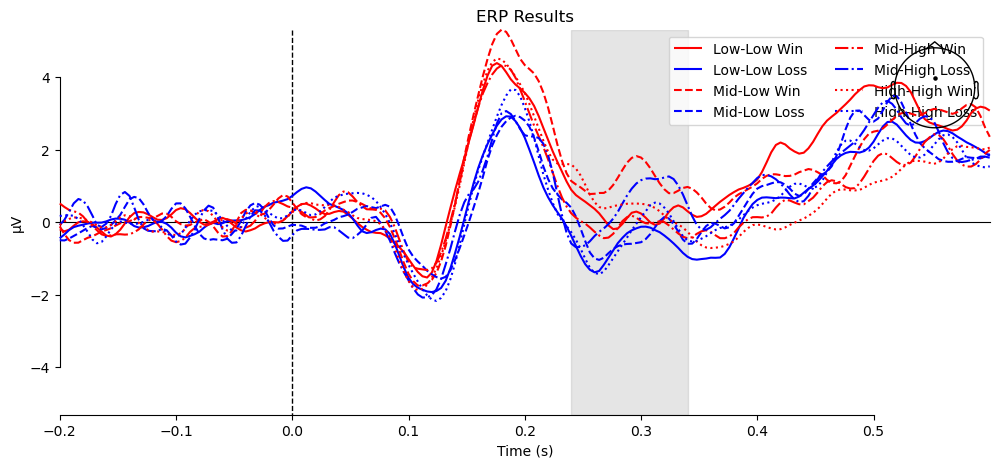

In [ ]:
# Define styles for the plot
colors = {
    'Low-Low Win': 'red', 'Low-Low Loss': 'blue',
    'Mid-Low Win': 'red', 'Mid-Low Loss': 'blue',
    'Mid-High Win': 'red', 'Mid-High Loss': 'blue',
    'High-High Win': 'red', 'High-High Loss': 'blue'
}
linestyles = {
    'Low-Low Win': '-', 'Low-Low Loss': '-',
    'Mid-Low Win': '--', 'Mid-Low Loss': '--',
    'Mid-High Win': '-.', 'Mid-High Loss': '-.',
    'High-High Win': ':', 'High-High Loss': ':'
}
plot_erp(grand_averages, channel, mean_window, colors=colors, linestyles=linestyles, title=f"ERP Results")

Calculated difference for: Low-Low
Calculated difference for: Mid-Low
Calculated difference for: Mid-High
Calculated difference for: High-High


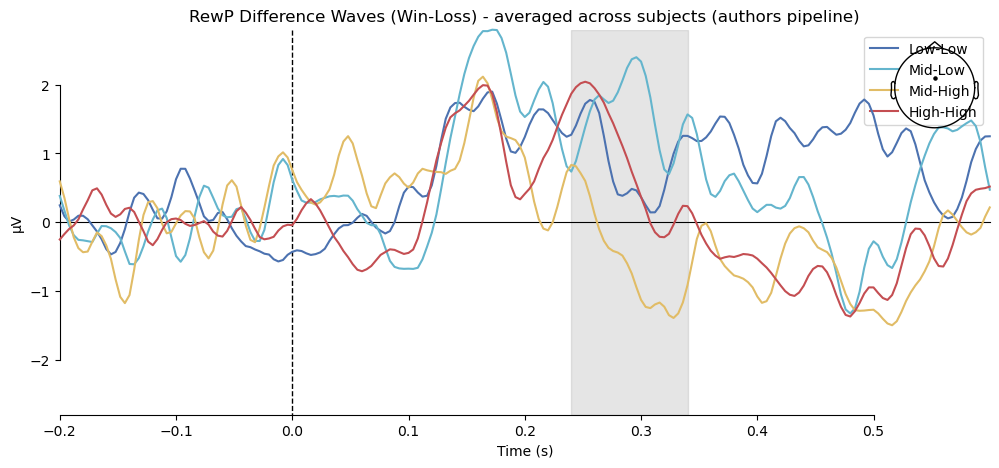

In [ ]:
diff_evokeds = {}

cases = [
    ('Low-Low', 'Low-Low Win', 'Low-Low Loss'),
    ('Mid-Low', 'Mid-Low Win', 'Mid-Low Loss'),
    ('Mid-High', 'Mid-High Win', 'Mid-High Loss'),
    ('High-High', 'High-High Win', 'High-High Loss')
]

for case_name, win_cond, loss_cond in cases:
    # Calculate Difference: Win - Loss
    diff = mne.combine_evoked(
        [grand_averages[win_cond], grand_averages[loss_cond]],
        weights=[1, -1]
    )
    diff.comment = case_name # Set name for plotting
    diff_evokeds[case_name] = diff
    print(f"Calculated difference for: {case_name}")

colors_diff = {
    'Low-Low': '#4C72B0',   # Muted Blue
    'Mid-Low': '#64B5CD',   # Soft Cyan
    'Mid-High': '#E1BC66',  # Sand/Gold
    'High-High': '#C44E52'  # Muted Crimson
}

plot_erp(diff_evokeds, channel, mean_window, colors=colors_diff, title=f"RewP Difference Waves (Win-Loss) - averaged across subjects (authors pipeline)")



KeyError: 'Low-Low'

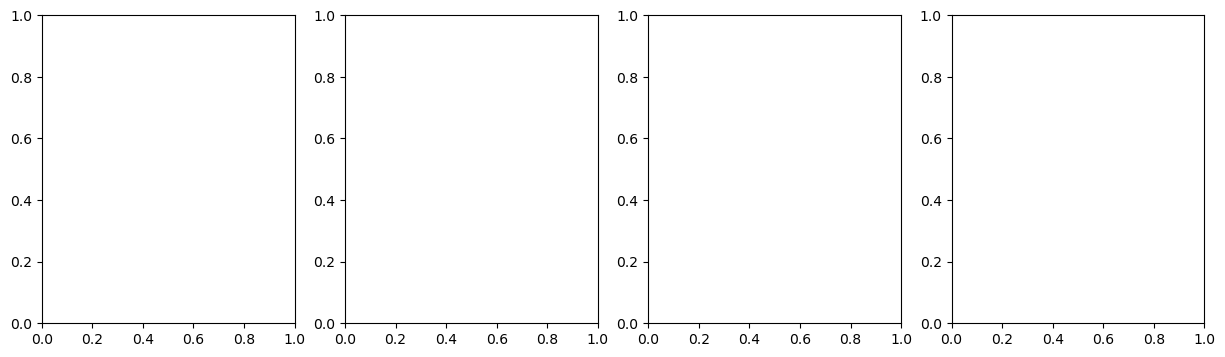

In [ ]:
import matplotlib.pyplot as plt

# List of your evoked objects (one per subject)
time_point = 0.300 # The specific time (e.g., 300ms) you want to compare

# Create a figure with a subplot for each subject
n_subs = len(group_evokeds)
fig, axes = plt.subplots(1, n_subs, figsize=(n_subs * 2, 3))

for i, evoked in enumerate(group_evokeds):
    # Plot topomap onto the specific subplot axis
    evoked.plot_topomap(times=time_point, axes=axes[i], colorbar=False, show=False)
    axes[i].set_title(f'Sub {i+1}')

plt.tight_layout()
plt.show()

Plotting Topomap for: Low-Low


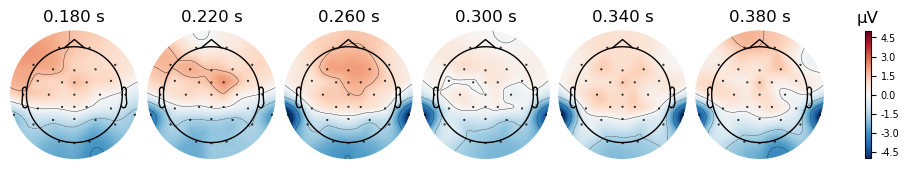

Plotting Topomap for: Mid-Low


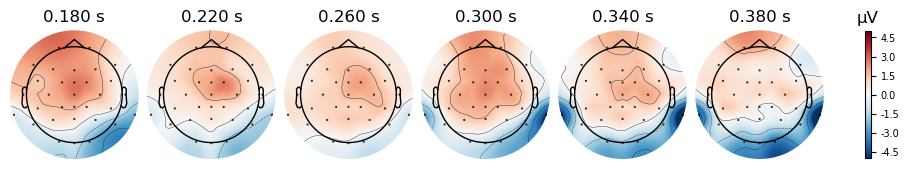

Plotting Topomap for: Mid-High


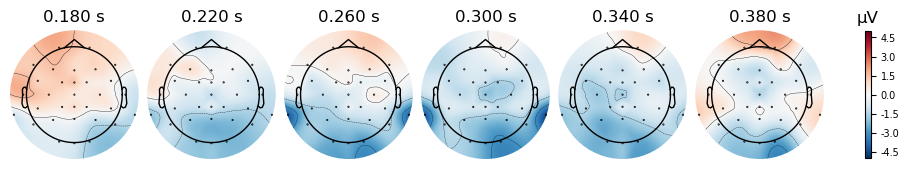

Plotting Topomap for: High-High


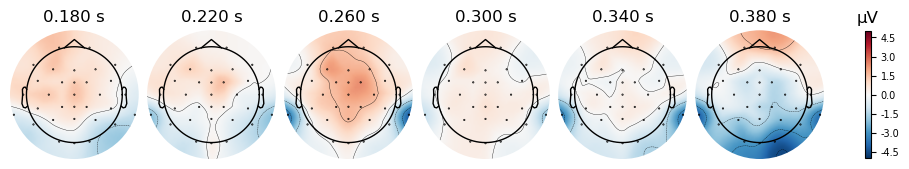

In [ ]:
times = [0.18, 0.22, 0.26, 0.30, 0.34, 0.38] # Fewer time points to save space
vlimit = (-5, 5)

for condition, evoked in diff_evokeds.items():
    print(f"Plotting Topomap for: {condition}")
    evoked.plot_topomap(times=times, ch_type='eeg', colorbar=True, vlim=vlimit)